# MobileNet v1 Architecture

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split

### Depthwise Separable convolution

In [2]:
# Depthwise conv + Pointwise Conv
def depthwise_separable_conv(x, filters, alpha, stride=1):
    # Depthwise
    x = layers.DepthwiseConv2D((3, 3), padding='same', strides=(stride, stride))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    # Pointwise
    x = layers.Conv2D(int(filters * alpha), (1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

In [3]:
# MobileNet Architecture
def MobileNetV1(input_shape, num_classes, alpha=1.0, rho=1.0):
    # 224 * 224 * 3
    reduced_input_shape = (int(input_shape[0] * rho), int(input_shape[1] * rho), input_shape[2])
    inputs = tf.keras.Input(shape=reduced_input_shape)
    print(inputs.shape)

    # Layer 1 -> Standard CONV
    x = layers.Conv2D(int(32 * alpha), (3, 3), padding='same', strides=(2, 2))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

  # Layer 2 -> Depthwise Separable Conv
    x = depthwise_separable_conv(x, 64, alpha)

    # Layer 3 -> Depthwise Separable Conv
    x = depthwise_separable_conv(x, 128, alpha, stride=2)

    # Layer 4 -> Depthwise Separable Conv
    x = depthwise_separable_conv(x, 128, alpha)

    # Layer 5 -> Depthwise Separable Conv
    x = depthwise_separable_conv(x, 256, alpha, stride=2)

    # Layer 6 -> Depthwise Separable Conv
    x = depthwise_separable_conv(x, 256, alpha)

    # Layer 7 -> Depthwise Separable Conv
    x = depthwise_separable_conv(x, 512, alpha, stride=2)

    # Layers 8-12 -> Depthwise Separable Conv (5 times)
    x = depthwise_separable_conv(x, 512, alpha)
    x = depthwise_separable_conv(x, 512, alpha)
    x = depthwise_separable_conv(x, 512, alpha)
    x = depthwise_separable_conv(x, 512, alpha)
    x = depthwise_separable_conv(x, 512, alpha)

    # Layer 13 -> Depthwise Separable Conv
    x = depthwise_separable_conv(x, 1024, alpha, stride=2)

    # Layer 14 -> Depthwise Separable Conv
    x = depthwise_separable_conv(x, 1024, alpha)

    # Global Average Pooling and Dense layer
    x = layers.AveragePooling2D(pool_size=(7, 7))(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the Model
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

In [5]:
# CIFAR-10 데이터셋 로드 및 전처리
def preprocess_image(image, label):
    # 32x32 이미지를 224x224로 리사이즈
    image = tf.image.resize(image, [224, 224])
    return image, label

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Training Dataset
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess_image).batch(32).shuffle(10000)

# Validation Dataset
validation_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_ds = validation_ds.map(preprocess_image).batch(32)

# Test Dataset
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(preprocess_image).batch(32)

In [6]:
input_shape = (224, 224, 3)
num_classes = 10
# (alpha=1.0, rho=1,0) in Default MobileNetV1
alpha = 1.0
rho = 1.0

In [7]:
model = MobileNetV1(input_shape, num_classes, alpha=alpha, rho=rho)
model.summary()

(None, 224, 224, 3)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 112, 112, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d (DepthwiseConv2D)   │ (None, 112, 112, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_1 (DepthwiseConv2D) │ (None, 56, 56, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_2 (DepthwiseConv2D) │ (None, 56, 56, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,250,058 (12.40 MB)

 Trainable params: 3,228,170 (12.31 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [9]:
# Compile the model with RMSprop
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
# Training
history = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 156s 88ms/step - accuracy: 0.3583 - loss: 1.7571 - val_accuracy: 0.5169 - val_loss: 1.5940
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 113s 87ms/step - accuracy: 0.6585 - loss: 0.9751 - val_accuracy: 0.6262 - val_loss: 1.1312
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 114s 87ms/step - accuracy: 0.7637 - loss: 0.6792 - val_accuracy: 0.6399 - val_loss: 1.2217
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 114s 88ms/step - accuracy: 0.8226 - loss: 0.5122 - val_accuracy: 0.7260 - val_loss: 0.9204
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 114s 88ms/step - accuracy: 0.8597 - loss: 0.4011 - val_accuracy: 0.7460 - val_loss: 0.8881
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 114s 88ms/step - accuracy: 0.8935 - loss: 0.3100 - val_accuracy: 0.7519 - val_loss: 0.9282
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 114s 88ms/step - accuracy: 0.9220 - loss: 0.2257 - val_accuracy: 0.8006 - val_loss: 0.7302
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 114s 88ms/step - accuracy: 

In [11]:
# Evaluate
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print(f'\nTest accuracy: {test_acc}')

313/313 - 7s - 22ms/step - accuracy: 0.8225 - loss: 0.7916

Test accuracy: 0.8224999904632568


# Visualization

In [12]:
import matplotlib.pyplot as plt

In [13]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

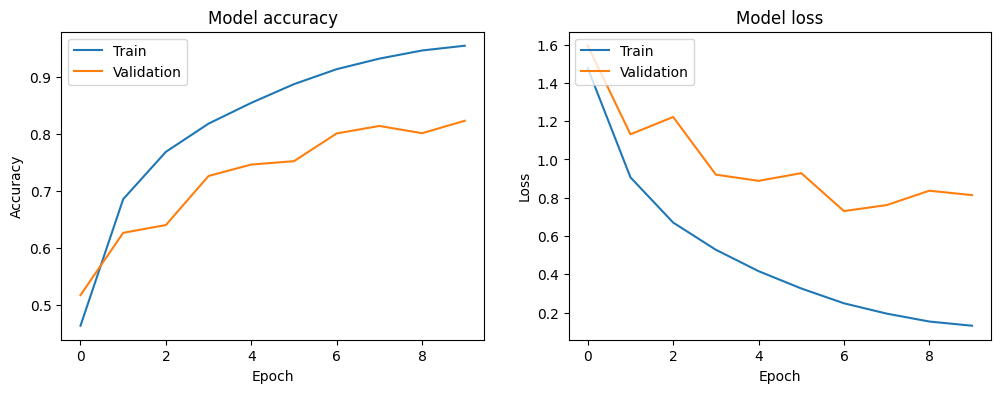

In [14]:
plot_history(history)